In [18]:
from pathlib import Path
import pandas as pd
import torch
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

In [19]:
CONFIG = {
    'hash_encoding': {
        'num_levels': 16,
        'level_dim': 2,
        'input_dim': 3,
        'log2_hashmap_size': 19,
        'base_resolution': 16
    },
    'mlp': {
        'num_layers': 3,  # Number of layers in geometric MLP
        'hidden_dim': 64,  # Hidden dimension size
    }
}

def load_torch_weights(file_path):
    """Load model weights from a checkpoint file."""
    try:
        weights = torch.load(file_path, map_location='cpu')
        return weights['model']
    except Exception as e:
        print(f"Error loading file {file_path}: {e}")
        return None
    
model_path_base = 'shared_data/GoldBag/base_000_000_000/checkpoints/final.pth'
model_path_x_180 = 'shared_data/GoldBag/x_180_000_000/checkpoints/final.pth'
model_path_test = 'shared_data/music_speaker/base_000_000_000/checkpoints/final.pth'


nerf_base = load_torch_weights(model_path_base)
nerf_x_180 = load_torch_weights(model_path_x_180)
nerf_test = load_torch_weights(model_path_test)

In [20]:
def extract_hash_encoding_structure(model_weights, num_levels=16, level_dim=2, input_dim=3, log2_hashmap_size=19, base_resolution=16):
    """
    Extract and organize hash encoding weights into hierarchical structure.
    
    Args:
        model_weights (dict): The loaded model weights dictionary
        num_levels (int): Number of levels in hash encoding
        level_dim (int): Dimension of encoding at each level
        input_dim (int): Input dimension (typically 3 for 3D)
        log2_hashmap_size (int): Log2 of maximum hash table size
        base_resolution (int): Base resolution of the grid
        
    Returns:
        dict: Hierarchical structure of hash encoding weights
    """
    # Extract hash encoding embeddings
    embeddings = model_weights['_orig_mod.grid_encoder.embeddings']
    
    # Calculate per-level parameters
    max_params = 2 ** log2_hashmap_size
    per_level_scale = np.exp2(np.log2(2048 / base_resolution) / (num_levels - 1))
    
    # Initialize structure to store weights
    hash_structure = {}
    offset = 0
    
    for level in range(num_levels):
        # Calculate resolution at this level
        resolution = int(np.ceil(base_resolution * (per_level_scale ** level)))
        
        # Calculate number of parameters for this level
        params_in_level = min(max_params, (resolution) ** input_dim)
        params_in_level = int(np.ceil(params_in_level / 8) * 8)  # make divisible by 8
        
        # Extract weights for this level
        level_weights = embeddings[offset:offset + params_in_level]
        
        # Store level information
        hash_structure[f'level_{level}'] = {
            'resolution': resolution,
            'num_params': params_in_level,
            'weights': level_weights,
            'weights_shape': level_weights.shape,
            'scale': per_level_scale ** level
        }
        
        offset += params_in_level
    
    # Add global information
    hash_structure['global_info'] = {
        'total_params': offset,
        'embedding_dim': level_dim,
        'base_resolution': base_resolution,
        'max_resolution': int(np.ceil(base_resolution * (per_level_scale ** (num_levels-1)))),
        'per_level_scale': per_level_scale
    }
    
    return hash_structure

In [21]:
mrhe_by_layer_base = extract_hash_encoding_structure(nerf_base)

mrhe_by_layer_x_180 = extract_hash_encoding_structure(nerf_x_180)

mrhe_by_layer_nerf_test = extract_hash_encoding_structure(nerf_test)

In [22]:
# base for CarrotKhanStatue
base_dict = {layer: info['weights'] for layer, info in mrhe_by_layer_base.items() if layer.startswith('level_')}

In [23]:
base_dict

{'level_0': tensor([[-0.0527,  0.0745],
         [-0.0633,  0.0900],
         [ 0.0477, -0.0399],
         ...,
         [ 0.0195, -0.0195],
         [-0.0060,  0.0123],
         [-0.0254,  0.0286]]),
 'level_1': tensor([[ 0.0489, -0.0540],
         [ 0.0505, -0.0430],
         [ 0.1126, -0.1024],
         ...,
         [-0.1858,  1.3382],
         [-0.0853,  0.7844],
         [ 1.1248,  0.3233]]),
 'level_2': tensor([[ 0.7296,  0.8847],
         [ 0.4061, -0.4562],
         [ 0.2873, -1.7652],
         ...,
         [-0.1646,  0.5048],
         [ 0.1691,  0.7151],
         [ 0.7422,  0.4330]]),
 'level_3': tensor([[-1.1570,  0.3944],
         [-1.3432,  0.2918],
         [-0.4597,  0.8367],
         ...,
         [-2.0928, -0.8483],
         [-0.2869,  0.1597],
         [ 0.3147,  0.0896]]),
 'level_4': tensor([[ 1.3124e-01,  5.4654e-01],
         [ 7.2911e-01,  6.1553e-01],
         [ 6.3836e-01,  6.5652e-01],
         ...,
         [ 2.9694e-05,  9.1772e-05],
         [-1.7237e-05, 

In [24]:
len(base_dict.get("level_15"))

524288

In [25]:
# turned 180 CarrotKhanStatue
x_180_dict = {layer: info['weights'] for layer, info in mrhe_by_layer_x_180.items() if layer.startswith('level_')}


In [26]:
x_180_dict

{'level_0': tensor([[-0.0149, -0.0826],
         [-0.0377,  0.0389],
         [-0.1371,  0.0194],
         ...,
         [-0.1298, -0.0240],
         [-0.0776, -0.0217],
         [-0.0061, -0.1078]]),
 'level_1': tensor([[-0.0826,  0.0391],
         [-0.0723,  0.0836],
         [ 0.0095,  0.0363],
         ...,
         [-0.2598,  0.3306],
         [-1.1073,  1.3116],
         [ 0.3155,  0.3042]]),
 'level_2': tensor([[ 0.0297,  0.3534],
         [-0.0220,  0.3889],
         [ 0.3779, -0.2701],
         ...,
         [ 0.5975, -0.0584],
         [ 1.0359,  0.4356],
         [ 0.6575, -0.7179]]),
 'level_3': tensor([[ 1.3479,  0.0942],
         [ 0.3616, -0.7315],
         [-0.1287, -0.6633],
         ...,
         [-0.1793, -0.2715],
         [ 0.4665,  0.3135],
         [ 0.4960, -0.4617]]),
 'level_4': tensor([[-5.1021e-01, -5.3559e-01],
         [-1.0912e+00, -9.9390e-01],
         [ 1.1099e+00, -8.9267e-02],
         ...,
         [ 6.1515e-05, -7.2461e-05],
         [-7.6264e-05, 

In [27]:
# different nerf to check back (currently Goldback)
test_dict = {layer: info['weights'] for layer, info in mrhe_by_layer_nerf_test.items() if layer.startswith('level_')}

In [28]:
test_dict

{'level_0': tensor([[-0.0370,  0.3134],
         [ 0.1355, -0.3484],
         [ 0.6165, -0.5062],
         ...,
         [-0.0609,  0.3730],
         [-0.1460,  0.2938],
         [ 0.2498, -0.0561]]),
 'level_1': tensor([[-0.4666, -0.5953],
         [ 0.1261, -0.0737],
         [ 0.3360,  0.0849],
         ...,
         [ 0.4212,  1.4194],
         [-0.3068,  0.5271],
         [-1.5910, -0.7300]]),
 'level_2': tensor([[-1.2166, -0.7106],
         [-0.5833,  0.1264],
         [ 0.1423,  0.4791],
         ...,
         [-0.5001, -0.6225],
         [-0.3334, -0.7670],
         [-0.8498, -0.3003]]),
 'level_3': tensor([[-1.1093,  0.4758],
         [-0.4522,  0.6262],
         [-0.2923,  0.2673],
         ...,
         [-0.3822,  0.0253],
         [-0.9949,  0.0428],
         [-0.5167, -0.3190]]),
 'level_4': tensor([[-1.0683e+00,  1.0311e+00],
         [ 1.8165e-01, -1.4492e+00],
         [-3.6803e-01, -1.4456e+00],
         ...,
         [-6.4396e-05,  6.8380e-05],
         [-4.6162e-05, 

In [29]:
import pandas as pd


def cosine_similarity_batch(A, B):
    """
    Calculates Cosine Similarity
    """
    A_norm = A / A.norm(dim=1, keepdim=True).clamp(min=1e-8)
    B_norm = B / B.norm(dim=1, keepdim=True).clamp(min=1e-8)
    return (A_norm * B_norm).sum(dim=1)


results = {
    "Level": [],
    "Mean CosineSim": [],
    "Min": [],
    "Max": [],
    "Std": []
}

# Calculate for x_180
for i in range(16):
    key = f'level_{i}'
    A = base_dict[key]
    B = x_180_dict[key]
    cos_sim = cosine_similarity_batch(A, B)
    results["Level"].append(key)
    results["Mean CosineSim"].append(cos_sim.mean().item())
    results["Min"].append(cos_sim.min().item())
    results["Max"].append(cos_sim.max().item())
    results["Std"].append(cos_sim.std().item())

# plot as df
df = pd.DataFrame(results)
print(df)


       Level  Mean CosineSim  Min  Max       Std
0    level_0        0.297799 -1.0  1.0  0.774717
1    level_1       -0.051599 -1.0  1.0  0.749437
2    level_2        0.017207 -1.0  1.0  0.718822
3    level_3       -0.004361 -1.0  1.0  0.623076
4    level_4        0.009994 -1.0  1.0  0.686716
5    level_5        0.077270 -1.0  1.0  0.780006
6    level_6        0.144368 -1.0  1.0  0.774667
7    level_7       -0.078629 -1.0  1.0  0.735070
8    level_8       -0.018576 -1.0  1.0  0.665879
9    level_9        0.019234 -1.0  1.0  0.701124
10  level_10       -0.006055 -1.0  1.0  0.677721
11  level_11       -0.002245 -1.0  1.0  0.722120
12  level_12       -0.006613 -1.0  1.0  0.632304
13  level_13       -0.002106 -1.0  1.0  0.726354
14  level_14       -0.003077 -1.0  1.0  0.695943
15  level_15       -0.005726 -1.0  1.0  0.705480


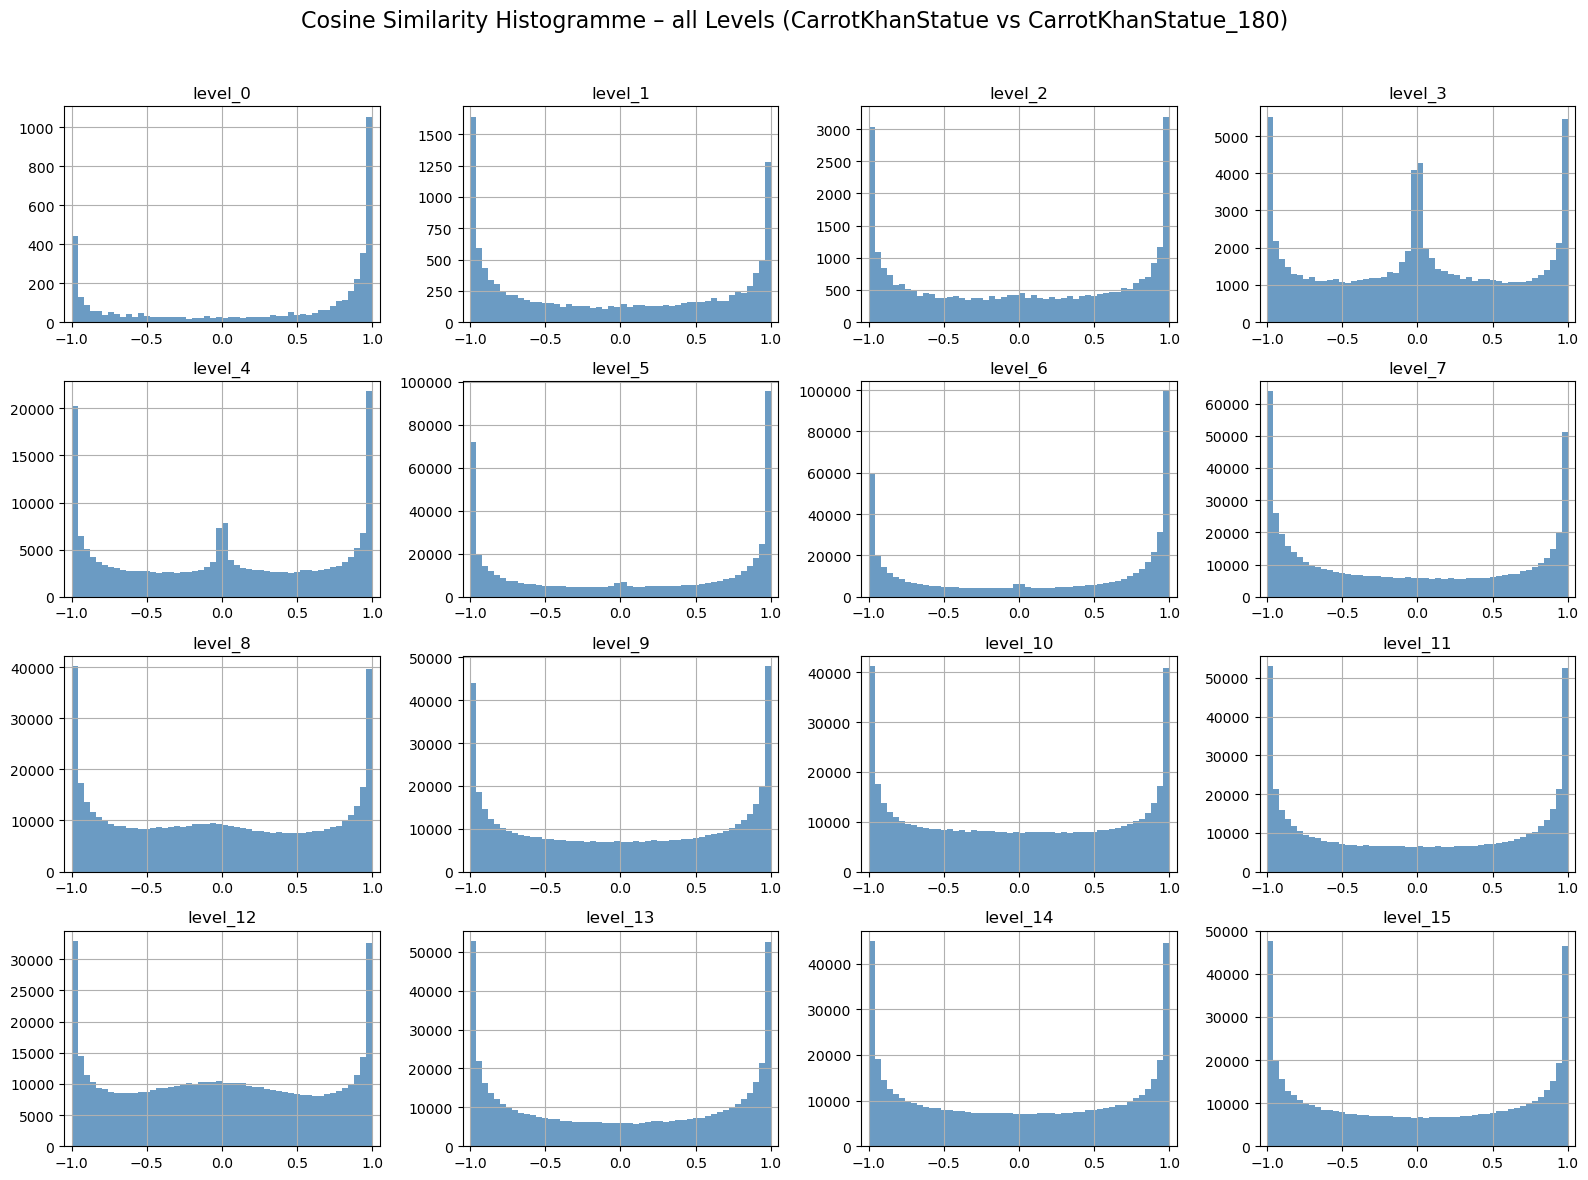

In [30]:
def cosine_similarity_batch(A, B):
    A_norm = A / A.norm(dim=1, keepdim=True).clamp(min=1e-8)
    B_norm = B / B.norm(dim=1, keepdim=True).clamp(min=1e-8)
    return (A_norm * B_norm).sum(dim=1)

# Grid vorbereiten
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
fig.suptitle("Cosine Similarity Histogramme – all Levels (CarrotKhanStatue vs CarrotKhanStatue_180)", fontsize=16)

for i in range(16):
    key = f'level_{i}'
    row, col = divmod(i, 4)
    ax = axes[row][col]

    A = base_dict[key]
    B = x_180_dict[key]
    sims = cosine_similarity_batch(A, B).cpu().numpy()

    ax.hist(sims, bins=50, color='steelblue', alpha=0.8)
    ax.set_title(key)
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


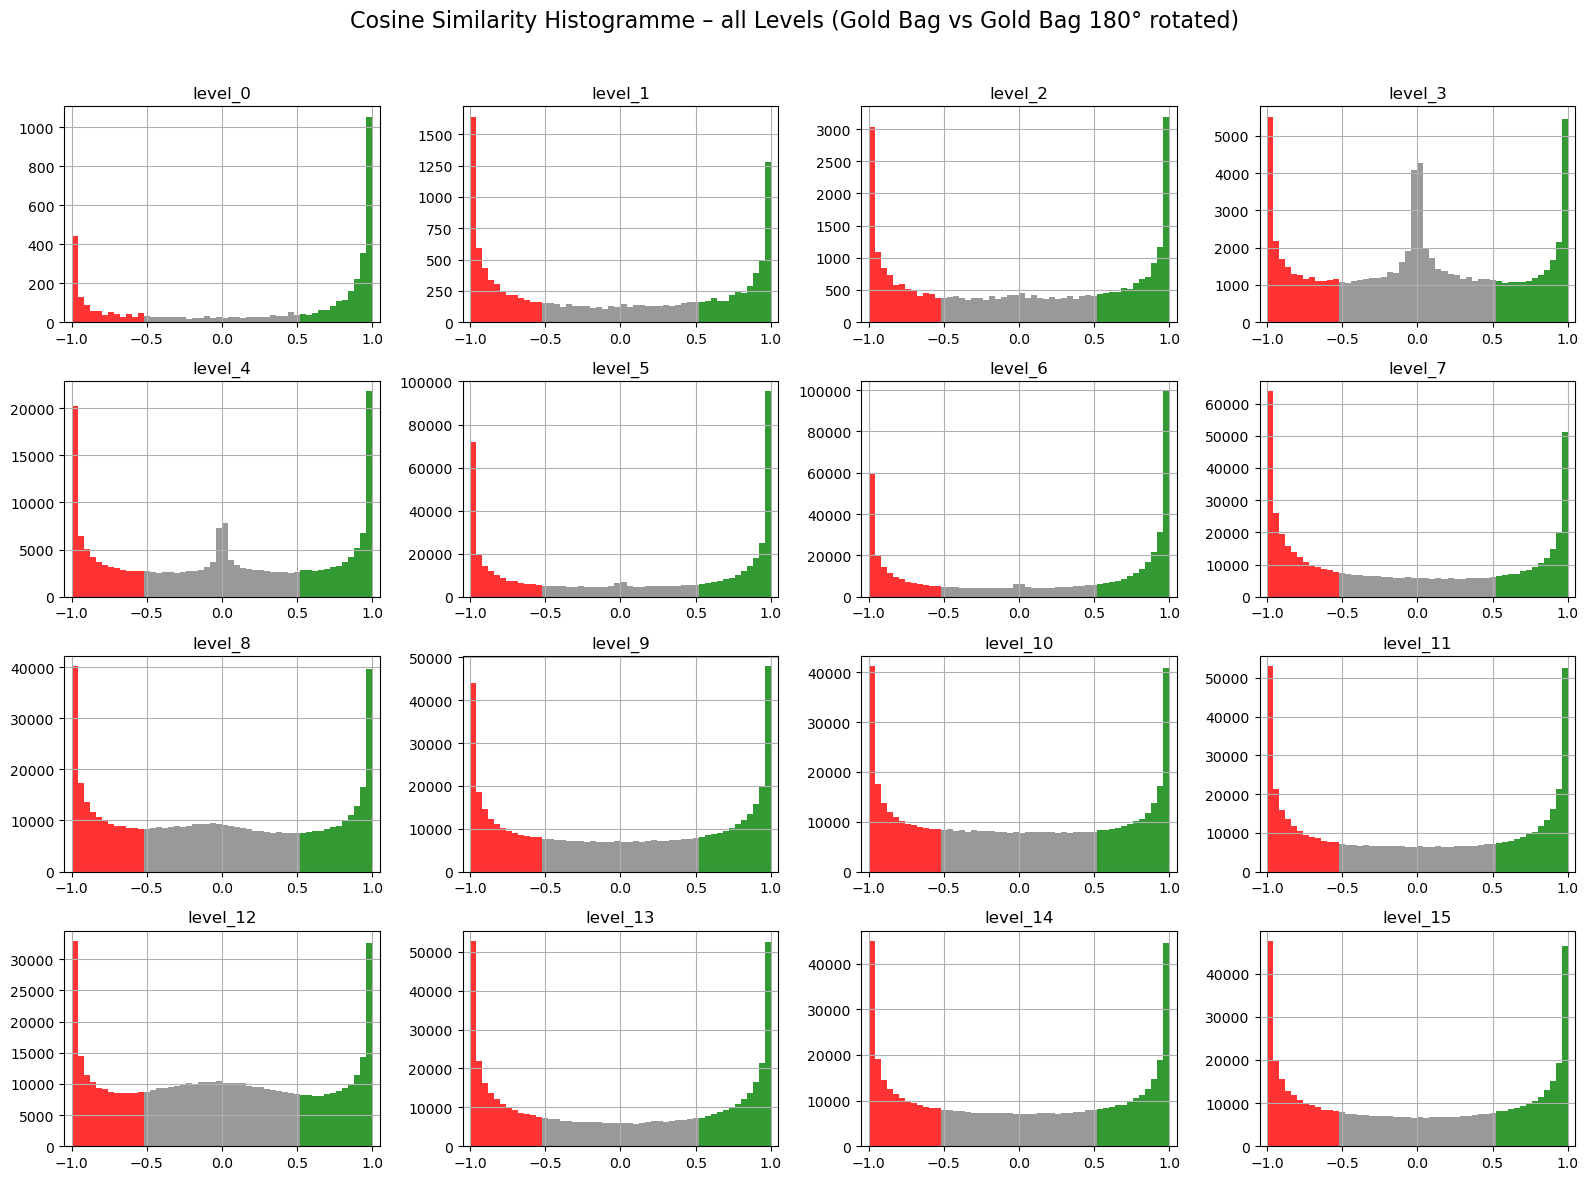

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_similarity_batch(A, B):
    A_norm = A / A.norm(dim=1, keepdim=True).clamp(min=1e-8)
    B_norm = B / B.norm(dim=1, keepdim=True).clamp(min=1e-8)
    return (A_norm * B_norm).sum(dim=1)

# Grid vorbereiten
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
fig.suptitle("Cosine Similarity Histogramme – all Levels (Gold Bag vs Gold Bag 180° rotated)", fontsize=16)

for i in range(16):
    key = f'level_{i}'
    row, col = divmod(i, 4)
    ax = axes[row][col]

    A = base_dict[key]
    B = x_180_dict[key]
    sims = cosine_similarity_batch(A, B).cpu().numpy()

    counts, bins = np.histogram(sims, bins=50, range=(-1, 1))
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_width = bins[1] - bins[0]

    # Farbzuordnung
    colors = []
    for center in bin_centers:
        if center < -0.5:
            colors.append('red')
        elif center > 0.5:
            colors.append('green')
        else:
            colors.append('gray')

    ax.bar(bin_centers, counts, width=bin_width, color=colors, alpha=0.8)
    ax.set_title(key)
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


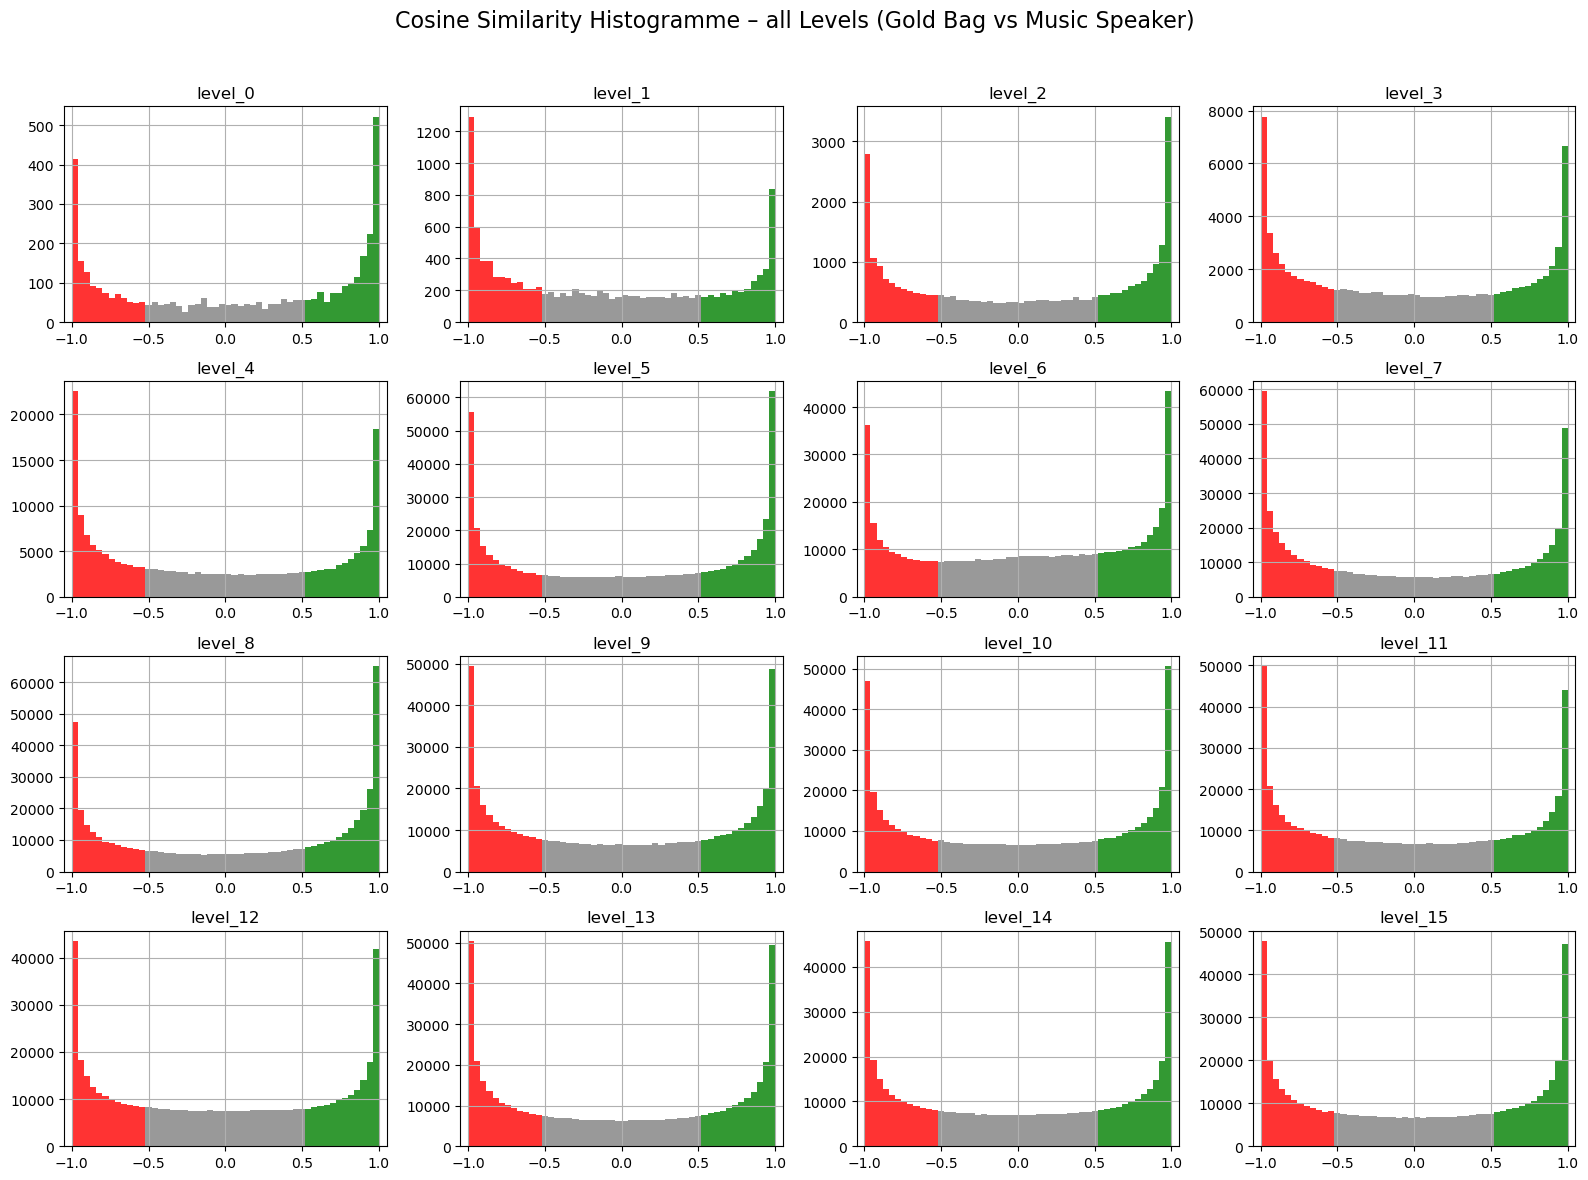

In [36]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_similarity_batch(A, B):
    A_norm = A / A.norm(dim=1, keepdim=True).clamp(min=1e-8)
    B_norm = B / B.norm(dim=1, keepdim=True).clamp(min=1e-8)
    return (A_norm * B_norm).sum(dim=1)

# Grid vorbereiten
fig, axes = plt.subplots(4, 4, figsize=(16, 12))
fig.suptitle("Cosine Similarity Histogramme – all Levels (Gold Bag vs Music Speaker)", fontsize=16)

for i in range(16):
    key = f'level_{i}'
    row, col = divmod(i, 4)
    ax = axes[row][col]

    A = base_dict[key]
    B = test_dict[key]
    sims = cosine_similarity_batch(A, B).cpu().numpy()

    counts, bins = np.histogram(sims, bins=50, range=(-1, 1))
    bin_centers = 0.5 * (bins[1:] + bins[:-1])
    bin_width = bins[1] - bins[0]

    # Farbzuordnung
    colors = []
    for center in bin_centers:
        if center < -0.5:
            colors.append('red')
        elif center > 0.5:
            colors.append('green')
        else:
            colors.append('gray')

    ax.bar(bin_centers, counts, width=bin_width, color=colors, alpha=0.8)
    ax.set_title(key)
    ax.set_xlim(-1.05, 1.05)
    ax.set_xticks([-1, -0.5, 0, 0.5, 1])
    ax.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
